In [297]:
import xgboost as xgb
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

In [298]:
def calculate_performance_metrics(y_true, y_pred, label_names):
    # Overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Hamming Loss: {hamming}\n')

    y_pred = np.insert(y_pred, 2, 0, axis=1)
    y_pred[:, 2] = np.where(y_pred[:, 0:2].sum(axis=1) == 0, 1, 0)

    y_true["未感染"] = y_true.iloc[:, 0:2].sum(axis=1)
    y_true["未感染"] = np.where(y_true["未感染"] == 0, 1, 0)

    # Individual label metrics
    for i, label in enumerate(label_names):
        print(f"Performance for label: {label}")

        # Extract predictions and true values for each label
        y_pred_label = y_pred[:, i]
        y_true_label = y_true[label].values

        # Calculate performance metrics
        accuracy_label = accuracy_score(y_true_label, y_pred_label)
        precision = precision_score(y_true_label, y_pred_label)
        recall = recall_score(y_true_label, y_pred_label)
        f1 = f1_score(y_true_label, y_pred_label)
        hamming = hamming_loss(y_true_label, y_pred_label)

        # Print performance metrics
        print(f"  Accuracy: {accuracy_label:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Hamming Loss: {hamming:.4f}\n")

    # Macro metrics
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Print macro metrics
    print(f'Macro Precision: {macro_precision:.4f}')
    print(f'Macro Recall: {macro_recall:.4f}')
    print(f'Macro F1 Score: {macro_f1:.4f}')

In [299]:
data_raw = pd.read_csv('../data/curated/combined_data_div_binned.csv')
data_reduced = pd.read_csv('../data/curated/combined_data_div_binned_reduced.csv')
label = pd.read_csv('../data/curated/combined_label.csv')
significant_features = pd.read_csv('../data/curated/significant_features.csv')
data_average = pd.read_csv('../data/curated/combined_data_average.csv')
significant_features = significant_features['0'].tolist()
label = label.iloc[:, 0:2]

# label['未感染'] = label.iloc[:, 0:2].sum(axis=1)
# label['未感染'] = np.where(label['未感染'] == 0, 1, 0)

In [300]:
data_selected = data_raw[significant_features]

In [301]:
# seperate those column with "div" in name into a new dataframe
data_div = data_selected.filter(regex='div')
data_div

,MCH_div_NEUT%,RDW-CV_div_NEUT%,HGB_div_NEUT%,HGB_div_HCT,EO%_div_IG%,MCH_div_NRBC#,PDW_div_LY,MCH_div_BASO%,P-LCR_div_NEUT%,PCT_div_BASO,...,HCT_div_EO%,RBC_div_LYBL%,HFLC1_div_NRBC#,PtAge_div_WBC,P-LCR_div_IG%,MCH_div_EO%,LY_div_BASO,PCT_div_EO,HGB_div_LY,MCHC_div_NEUT%
0,3.0,11.0,1.0,6.0,4.0,3.0,3.0,1.0,5.0,1.0,...,1.0,1.0,6.0,11.0,1.0,1.0,3.0,1.0,1.0,5.0
1,6.0,8.0,4.0,9.0,10.0,10.0,11.0,1.0,5.0,1.0,...,4.0,7.0,3.0,11.0,11.0,5.0,3.0,6.0,11.0,4.0
2,2.0,1.0,1.0,10.0,4.0,10.0,5.0,7.0,1.0,1.0,...,5.0,9.0,6.0,3.0,5.0,6.0,3.0,4.0,4.0,2.0
3,2.0,1.0,1.0,10.0,9.0,10.0,9.0,1.0,2.0,1.0,...,6.0,9.0,3.0,4.0,9.0,7.0,2.0,6.0,10.0,2.0
4,3.0,7.0,4.0,9.0,8.0,5.0,8.0,9.0,5.0,9.0,...,9.0,9.0,7.0,6.0,10.0,9.0,9.0,7.0,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966,6.0,7.0,6.0,6.0,1.0,1.0,5.0,1.0,4.0,4.0,...,7.0,7.0,4.0,8.0,4.0,7.0,4.0,7.0,10.0,5.0
7967,3.0,3.0,1.0,10.0,2.0,1.0,7.0,1.0,4.0,1.0,...,4.0,9.0,1.0,8.0,2.0,6.0,2.0,6.0,11.0,3.0
7968,11.0,11.0,11.0,8.0,5.0,1.0,1.0,1.0,11.0,5.0,...,1.0,3.0,4.0,8.0,1.0,1.0,6.0,1.0,5.0,11.0
7969,6.0,7.0,6.0,2.0,1.0,1.0,6.0,1.0,5.0,1.0,...,7.0,9.0,4.0,9.0,4.0,7.0,3.0,9.0,10.0,4.0


In [302]:
data_original = data_selected.drop(data_div.columns, axis=1)

### Original data

In [303]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(data_original, label, test_size=0.2, random_state=42)


In [304]:
label

,FYZ-IgM,甲流
0,0,1
1,0,0
2,1,0
3,1,0
4,1,0
...,...,...
7966,0,0
7967,0,0
7968,0,0
7969,0,0


In [305]:
from sklearn.utils.class_weight import compute_sample_weight

# 计算样本权重，为异常值赋予更高的权重
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_original)

In [306]:
# 创建 XGBoost 和 LightGBM 模型
xgb_model_original = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=1.0))

# 训练模型
xgb_model_original.fit(X_train_original, y_train_original, sample_weight=sample_weights)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
             

In [307]:
# 进行预测
xgb_predictions_original = xgb_model_original.predict(X_test_original)

# 集成预测
np.argmax(xgb_predictions_original, axis=1)


array([0, 0, 1, ..., 1, 0, 0])

In [308]:
label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_test_original, xgb_predictions_original, label_names)

Accuracy: 0.580564263322884
Hamming Loss: 0.2347962382445141

Performance for label: FYZ-IgM
  Accuracy: 0.8188
  Precision: 0.7043
  Recall: 0.6383
  F1 Score: 0.6697
  Hamming Loss: 0.1812

Performance for label: 甲流
  Accuracy: 0.7116
  Precision: 0.5513
  Recall: 0.6379
  F1 Score: 0.5915
  Hamming Loss: 0.2884

Performance for label: 未感染
  Accuracy: 0.6508
  Precision: 0.5931
  Recall: 0.5410
  F1 Score: 0.5659
  Hamming Loss: 0.3492

Macro Precision: 0.6163
Macro Recall: 0.6058
Macro F1 Score: 0.6090


### Top 20 original feature

In [309]:
# print feature importance
xgb_model_original.estimators_[0].feature_importances_
xgb_model_original.estimators_[1].feature_importances_

# save the top 20 features
feature_importance_original = pd.DataFrame({'feature': X_train_original.columns, 'importance': xgb_model_original.estimators_[0].feature_importances_})
feature_importance_original = feature_importance_original.sort_values(by='importance', ascending=False)
feature_importance_original = feature_importance_original.iloc[0:18, :]

In [310]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(data_original[feature_importance_original['feature']], label, test_size=0.2, random_state=2)


In [311]:

# 创建 XGBoost模型
xgb_model_original = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss'))

# 训练模型
xgb_model_original.fit(X_train_original, y_train_original, sample_weight=sample_weights)

# 进行预测
xgb_predictions_original = xgb_model_original.predict(X_test_original)

# 集成预测
np.argmax(xgb_predictions_original, axis=1)

label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_test_original, xgb_predictions_original, label_names)

Accuracy: 0.587460815047022
Hamming Loss: 0.2263322884012539

Performance for label: FYZ-IgM
  Accuracy: 0.8395
  Precision: 0.7942
  Recall: 0.5969
  F1 Score: 0.6816
  Hamming Loss: 0.1605

Performance for label: 甲流
  Accuracy: 0.7078
  Precision: 0.5650
  Recall: 0.5028
  F1 Score: 0.5321
  Hamming Loss: 0.2922

Performance for label: 未感染
  Accuracy: 0.6376
  Precision: 0.5576
  Recall: 0.6642
  F1 Score: 0.6063
  Hamming Loss: 0.3624

Macro Precision: 0.6390
Macro Recall: 0.5880
Macro F1 Score: 0.6067


### div features (衍生feature)

In [312]:
X_train_div, X_test_div, y_train_div, y_test_div = train_test_split(data_div, label, test_size=0.2, random_state=42)


In [313]:
xgb_model_div = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=0.6))

# 训练模型
xgb_model_div.fit(X_train_div, y_train_div, sample_weight=sample_weights)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
             

In [314]:
# 进行预测
xgb_predictions_div = xgb_model_div.predict(X_test_div)

# 集成预测
np.argmax(xgb_predictions_div, axis=1)

array([0, 0, 0, ..., 1, 1, 0])

In [315]:
label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_test_div, xgb_predictions_div, label_names)

Accuracy: 0.5918495297805643
Hamming Loss: 0.2244514106583072

Performance for label: FYZ-IgM
  Accuracy: 0.8370
  Precision: 0.8119
  Recall: 0.5643
  F1 Score: 0.6658
  Hamming Loss: 0.1630

Performance for label: 甲流
  Accuracy: 0.7141
  Precision: 0.5696
  Recall: 0.5172
  F1 Score: 0.5422
  Hamming Loss: 0.2859

Performance for label: 未感染
  Accuracy: 0.6451
  Precision: 0.5647
  Recall: 0.6826
  F1 Score: 0.6181
  Hamming Loss: 0.3549

Macro Precision: 0.6488
Macro Recall: 0.5880
Macro F1 Score: 0.6087


In [316]:
# print feature importance
xgb_model_div.estimators_[0].feature_importances_
xgb_model_div.estimators_[1].feature_importances_

# save the top 20 features
feature_importance_div = pd.DataFrame({'feature': X_train_div.columns, 'importance': xgb_model_div.estimators_[0].feature_importances_})
feature_importance_div = feature_importance_div.sort_values(by='importance', ascending=False)
feature_importance_div = feature_importance_div.iloc[0:40, :]

In [317]:
X_train_div, X_test_div, y_train_div, y_test_div = train_test_split(data_div[feature_importance_div['feature']], label, test_size=0.2, random_state=42)

In [318]:
# 创建 XGBoost
xgb_model_div = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss'))

# 训练模型
xgb_model_div.fit(X_train_div, y_train_div, sample_weight=sample_weights)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
             

In [319]:
# 进行预测
xgb_predictions_div = xgb_model_div.predict(X_test_div)

# 集成预测
np.argmax(xgb_predictions_div, axis=1)

array([0, 0, 0, ..., 1, 1, 0])

In [320]:
label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_test_div, xgb_predictions_div, label_names)

Accuracy: 0.5786833855799373
Hamming Loss: 0.24012539184952977

Performance for label: FYZ-IgM
  Accuracy: 0.8263
  Precision: 0.7358
  Recall: 0.6187
  F1 Score: 0.6722
  Hamming Loss: 0.1737

Performance for label: 甲流
  Accuracy: 0.6934
  Precision: 0.5266
  Recall: 0.6264
  F1 Score: 0.5722
  Hamming Loss: 0.3066

Performance for label: 未感染
  Accuracy: 0.6489
  Precision: 0.5900
  Recall: 0.5425
  F1 Score: 0.5652
  Hamming Loss: 0.3511

Macro Precision: 0.6174
Macro Recall: 0.5959
Macro F1 Score: 0.6032


### 衍生data

In [321]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(data_average, label, test_size=0.2, random_state=42)


In [322]:
xgb_model_avg = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=0.6))

# 训练模型
xgb_model_avg.fit(X_train_avg, y_train_avg, sample_weight=sample_weights)

# 进行预测
xgb_predictions_avg = xgb_model_avg.predict(X_test_avg)

# 集成预测
np.argmax(xgb_predictions_avg, axis=1)

array([0, 0, 0, ..., 0, 0, 1])

In [323]:
label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_test_avg, xgb_predictions_avg, label_names)

Accuracy: 0.7473354231974921
Hamming Loss: 0.18213166144200627

Performance for label: FYZ-IgM
  Accuracy: 0.8082
  Precision: 0.6775
  Recall: 0.6362
  F1 Score: 0.6562
  Hamming Loss: 0.1918

Performance for label: 甲流
  Accuracy: 0.8276
  Precision: 0.7622
  Recall: 0.6877
  F1 Score: 0.7231
  Hamming Loss: 0.1724

Performance for label: 未感染
  Accuracy: 0.9223
  Precision: 0.8594
  Recall: 0.9747
  F1 Score: 0.9134
  Hamming Loss: 0.0777

Macro Precision: 0.7664
Macro Recall: 0.7662
Macro F1 Score: 0.7642


In [324]:
data_average

,cumulative_mean_PtAge,cumulative_mean_WBC,cumulative_mean_RBC,cumulative_mean_HGB,cumulative_mean_HCT,cumulative_mean_MCV,cumulative_mean_MCH,cumulative_mean_MCHC,cumulative_mean_PLT,cumulative_mean_RDW-SD,...,cumulative_mean_MONO%,cumulative_mean_EO%,cumulative_mean_BASO%,cumulative_mean_IG#,cumulative_mean_IG%,cumulative_mean_CRP,cumulative_mean_HFLC1,cumulative_mean_HFLC2,cumulative_mean_NRBC#,cumulative_mean_NRBC%
0,89.000000,8.690000,3.110000,78.000000,23.600000,75.900000,25.200000,331.000000,257.000000,57.700000,...,3.900000,6.000000,0.200000,0.070000,0.800000,17.867402,0.010000,0.200000,0.000000,0.000000
1,61.500000,5.845000,3.700000,106.000000,31.750000,84.450000,28.250000,333.500000,195.500000,51.900000,...,7.850000,3.500000,0.250000,0.035000,0.400000,9.408701,0.005000,0.150000,0.000000,0.000000
2,48.666667,11.013333,3.900000,115.333333,34.366667,87.000000,29.200000,335.000000,226.000000,48.600000,...,6.933333,2.533333,0.200000,0.030000,0.300000,19.939134,0.006667,0.100000,0.000000,0.000000
3,40.750000,11.130000,3.922500,118.000000,34.950000,88.275000,29.775000,337.000000,233.250000,47.025000,...,6.425000,1.975000,0.225000,0.022500,0.225000,23.704351,0.005000,0.075000,0.000000,0.000000
4,35.000000,10.160000,4.092000,122.000000,36.180000,87.860000,29.600000,336.800000,223.000000,45.820000,...,7.160000,1.600000,0.180000,0.018000,0.180000,23.345480,0.008000,0.120000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966,27.391605,7.691973,4.667849,138.208333,41.310341,88.613855,29.642997,334.126381,232.816140,41.984714,...,9.657696,0.946524,0.237575,0.020930,0.242357,17.871208,0.020760,0.289779,0.000337,0.003556
7967,27.391807,7.691865,4.667768,138.206174,41.309575,88.613728,29.643054,334.127620,232.817292,41.984239,...,9.657701,0.946493,0.237583,0.020930,0.242364,17.869778,0.020757,0.289743,0.000337,0.003556
7968,27.392009,7.691601,4.667824,138.207528,41.310013,88.613588,29.642986,334.127478,232.816688,41.984442,...,9.658284,0.947227,0.237578,0.020932,0.242422,17.869105,0.020756,0.289731,0.000337,0.003556
7969,27.392838,7.691396,4.667855,138.208757,41.310601,88.614227,29.643044,334.125957,232.821729,41.984331,...,9.659142,0.947133,0.237586,0.020931,0.242416,17.867063,0.020754,0.289720,0.000337,0.003556


In [325]:
# print feature importance
xgb_model_avg.estimators_[0].feature_importances_
xgb_model_avg.estimators_[1].feature_importances_

# save the top 20 features
feature_importance_avg = pd.DataFrame({'feature': X_train_avg.columns, 'importance': xgb_model_avg.estimators_[0].feature_importances_})
feature_importance_avg = feature_importance_avg.sort_values(by='importance', ascending=False)
feature_importance_avg = feature_importance_avg.iloc[0:12, :]

In [326]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(data_average[feature_importance_avg['feature']], label, test_size=0.2, random_state=42)

xgb_model_avg = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=0.6))

# 训练模型
xgb_model_avg.fit(X_train_avg, y_train_avg, sample_weight=sample_weights)

# 进行预测
xgb_predictions_avg = xgb_model_avg.predict(X_test_avg)

# 集成预测
np.argmax(xgb_predictions_avg, axis=1)

label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_test_avg, xgb_predictions_avg, label_names)

Accuracy: 0.7517241379310344
Hamming Loss: 0.17648902821316614

Performance for label: FYZ-IgM
  Accuracy: 0.8245
  Precision: 0.7178
  Recall: 0.6427
  F1 Score: 0.6782
  Hamming Loss: 0.1755

Performance for label: 甲流
  Accuracy: 0.8226
  Precision: 0.7661
  Recall: 0.6590
  F1 Score: 0.7085
  Hamming Loss: 0.1774

Performance for label: 未感染
  Accuracy: 0.9097
  Precision: 0.8348
  Recall: 0.9791
  F1 Score: 0.9012
  Hamming Loss: 0.0903

Macro Precision: 0.7729
Macro Recall: 0.7603
Macro F1 Score: 0.7626


### Combined data

In [414]:
# combined data_div[feature_importance_div['feature']], data_average[feature_importance_avg['feature']] and data_original[feature_importance_original['feature']]
data_combined = pd.concat([data_div[feature_importance_div['feature']], data_average[feature_importance_avg['feature']], data_original[feature_importance_original['feature']]], axis=1)

In [415]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(data_combined, label, test_size=0.2, random_state=42)

In [416]:
sample_weights=compute_sample_weight(class_weight='balanced', y=y_train_combined)

### Model for high recall

In [417]:
# 使用 GridSearchCV 得到的最佳参数
best_params = {
'estimator__gamma': 0, 'estimator__learning_rate': 0.001, 'estimator__max_depth': 1, 'estimator__n_estimators': 50}

# 创建模型
xgb_model = xgb.XGBClassifier(**best_params, eval_metric=['logloss', 'auc', 'error'], num_round=100)
multioutput_model = MultiOutputClassifier(xgb_model, n_jobs=-1)

# 训练模型
multioutput_model.fit(X_train_combined, y_train_combined, sample_weight=sample_weights)


/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:13:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth", "estimator__n_estimators", "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:13:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth", "estimator__n_estimators", "num_round" } are not used.

  warnings.warn(smsg, UserWarning)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              estimator__gamma=0,
                                              estimator__learning_rate=0.001,
                                              estimator__max_depth=1,
                                              estimator__n_estimators=50,
                                              eval_metric=['logloss', 'auc',
                                                           'error'],
              

In [418]:
# 进行预测
xgb_predictions_comb = multioutput_model.predict(X_test_combined)
# lgb_predictions = lgb_model.predict(X_test)

# 集成预测
# final_predictions = (xgb_predictions + lgb_predictions) / 2
np.argmax(xgb_predictions_comb, axis=1)

array([0, 0, 0, ..., 1, 0, 0])

In [419]:
label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_test_combined, xgb_predictions_comb, label_names)

Accuracy: 0.8432601880877743
Hamming Loss: 0.10626959247648902

Performance for label: FYZ-IgM
  Accuracy: 0.8796
  Precision: 0.8027
  Recall: 0.7712
  F1 Score: 0.7867
  Hamming Loss: 0.1204

Performance for label: 甲流
  Accuracy: 0.9078
  Precision: 0.8492
  Recall: 0.8736
  F1 Score: 0.8612
  Hamming Loss: 0.0922

Performance for label: 未感染
  Accuracy: 0.9624
  Precision: 0.9383
  Recall: 0.9747
  F1 Score: 0.9561
  Hamming Loss: 0.0376

Macro Precision: 0.8634
Macro Recall: 0.8732
Macro F1 Score: 0.8680


### 尝试用两个模型，第一个测试他是否属于任何一个阳性范围，第二个再细分是哪一种病
- 都是xgboost model

In [374]:
best_params = {
'estimator__gamma': 0, 'learning_rate': 0.05, 'estimator__learning_rate': 0.001, 
'n_estimators': 400, 'estimator__max_depth': 3, 'min_child_weight': 6, 'gamma': 0.6, 'colsample_bytree': 0.8,
'reg_alpha': 2, 'reg_lambda': 0.1}

In [375]:
# 创建一个新的目标变量，表示样本是否属于任何类别
y_train_any = (y_train_combined.sum(axis=1) > 0).astype(int)

# 创建并训练第一阶段的模型
model_any = xgb.XGBClassifier(**best_params, eval_metric=['logloss', 'auc', 'error'], num_round=300, scale_pos_weight=0.6)
model_any.fit(X_train_combined, y_train_any, sample_weight=sample_weights)

[16:46:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth", "num_round" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, estimator__gamma=0,
              estimator__learning_rate=0.001, estimator__max_depth=3,
              eval_metric=['logloss', 'auc', 'error'], feature_types=None,
              gamma=0.6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, ...)

In [376]:
# from sklearn.model_selection import GridSearchCV

# cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
# other_params = {'learning_rate': 0.03, 'n_estimators': 400, 'max_depth': 6, 'min_child_weight': 1, 'seed': 0,
#                 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1, 
#                 'min_child_weight': 6, 'colsample_bytree': 0.8, 'reg_alpha': 2, 'reg_lambda': 0.1}

# # do a grid search
# model_any = xgb.XGBClassifier(**other_params, eval_metric=['logloss', 'auc', 'error'], num_round=300, scale_pos_weight=0.6)
# model_any.fit(X_train_combined, y_train_any, sample_weight=sample_weights)
# grid_search = GridSearchCV(model_any, cv_params, scoring='r2', cv=3, verbose=1, n_jobs=-1)
# grid_search.fit(X_train_combined, y_train_any, sample_weight=sample_weights)

# # 查看最佳参数
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)


In [377]:
# 第二阶段的模型
multioutput_model_final = MultiOutputClassifier(xgb.XGBClassifier(**best_params, eval_metric=['logloss', 'auc', 'error']))
multioutput_model_final.fit(X_train_combined, y_train_combined, sample_weight=sample_weights)

[16:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth" } are not used.

[16:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth" } are not used.



MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              estimator__gamma=0,
                                              estimator__learning_rate=0.001,
                                              estimator__max_depth=3,
                                              eval_metric=['logloss', 'auc',
                                                           'error'],
                                              feature_types=None, gamma=0.6,
                                              grow_policy=

In [378]:
# check train accuracy
test = multioutput_model_final.predict(X_train_combined)
label_names = ['FYZ-IgM', '甲流', '未感染']
calculate_performance_metrics(y_train_combined, test, label_names)

Accuracy: 0.918444165621079
Hamming Loss: 0.05152132998745295

Performance for label: FYZ-IgM
  Accuracy: 0.9545
  Precision: 0.9151
  Recall: 0.9243
  F1 Score: 0.9197
  Hamming Loss: 0.0455

Performance for label: 甲流
  Accuracy: 0.9424
  Precision: 0.8705
  Recall: 0.9766
  F1 Score: 0.9205
  Hamming Loss: 0.0576

Performance for label: 未感染
  Accuracy: 0.9777
  Precision: 0.9907
  Recall: 0.9558
  F1 Score: 0.9729
  Hamming Loss: 0.0223

Macro Precision: 0.9254
Macro Recall: 0.9522
Macro F1 Score: 0.9377


In [379]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(data_combined, label, test_size=0.2, random_state=42)

In [380]:
label_names = ['FYZ-IgM', '甲流', '未感染']

# 第一阶段的预测
preds_any = model_any.predict(X_test_combined)

# 第二阶段的预测
preds_labels = multioutput_model_final.predict(X_test_combined[preds_any > 0])

# 预测结果初始化为全零数组
xgb_predictions_comb = np.zeros_like(y_test_combined)

# 只对第一阶段预测为正的样本填入第二阶段的预测结果
xgb_predictions_comb[preds_any > 0] = preds_labels

# 每行新插入一个值，将xgb_predictions_comb是一个numpy.ndarray中两列都为0的样本标记为1
xgb_predictions_comb = np.insert(xgb_predictions_comb, 2, 0, axis=1)
xgb_predictions_comb[:, 2] = np.where(xgb_predictions_comb[:, 0:2].sum(axis=1) == 0, 1, 0)

y_test_combined["未感染"] = y_test_combined.iloc[:, 0:2].sum(axis=1)
y_test_combined["未感染"] = np.where(y_test_combined["未感染"] == 0, 1, 0)

for i, l in enumerate(label_names):
    print(f"Performance for label: {l}")

    # 提取每个标签的预测和真实值
    y_pred_label = xgb_predictions_comb[:, i]
    y_true_label = y_test_combined[l].values

    # 计算性能指标
    accuracy = accuracy_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    hamming = hamming_loss(y_true_label, y_pred_label)

    # 打印性能指标
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}\n")
    print(f"  Hamming Loss: {hamming:.4f}\n")

# Macro metrics
macro_precision = precision_score(y_test_combined, xgb_predictions_comb, average='macro')
macro_recall = recall_score(y_test_combined, xgb_predictions_comb, average='macro')
macro_f1 = f1_score(y_test_combined, xgb_predictions_comb, average='macro')

# Print macro metrics
print(f'Macro Precision: {macro_precision:.4f}')
print(f'Macro Recall: {macro_recall:.4f}')
print(f'Macro F1 Score: {macro_f1:.4f}')



Performance for label: FYZ-IgM
  Accuracy: 0.8865
  Precision: 0.8022
  Recall: 0.8039
  F1 Score: 0.8030

  Hamming Loss: 0.1135

Performance for label: 甲流
  Accuracy: 0.9135
  Precision: 0.8380
  Recall: 0.9119
  F1 Score: 0.8734

  Hamming Loss: 0.0865

Performance for label: 未感染
  Accuracy: 0.9793
  Precision: 0.9790
  Recall: 0.9717
  F1 Score: 0.9753

  Hamming Loss: 0.0207

Macro Precision: 0.8731
Macro Recall: 0.8958
Macro F1 Score: 0.8839


In [381]:
# count numer of 1 in each column
y_train_combined['FYZ-IgM'].value_counts()

0    4580
1    1796
Name: FYZ-IgM, dtype: int64

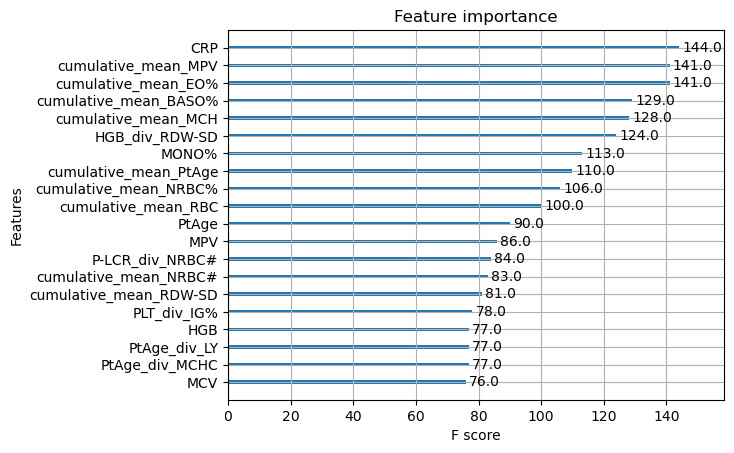

In [382]:
# plot feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(multioutput_model_final.estimators_[0], max_num_features=20)
plt.show()

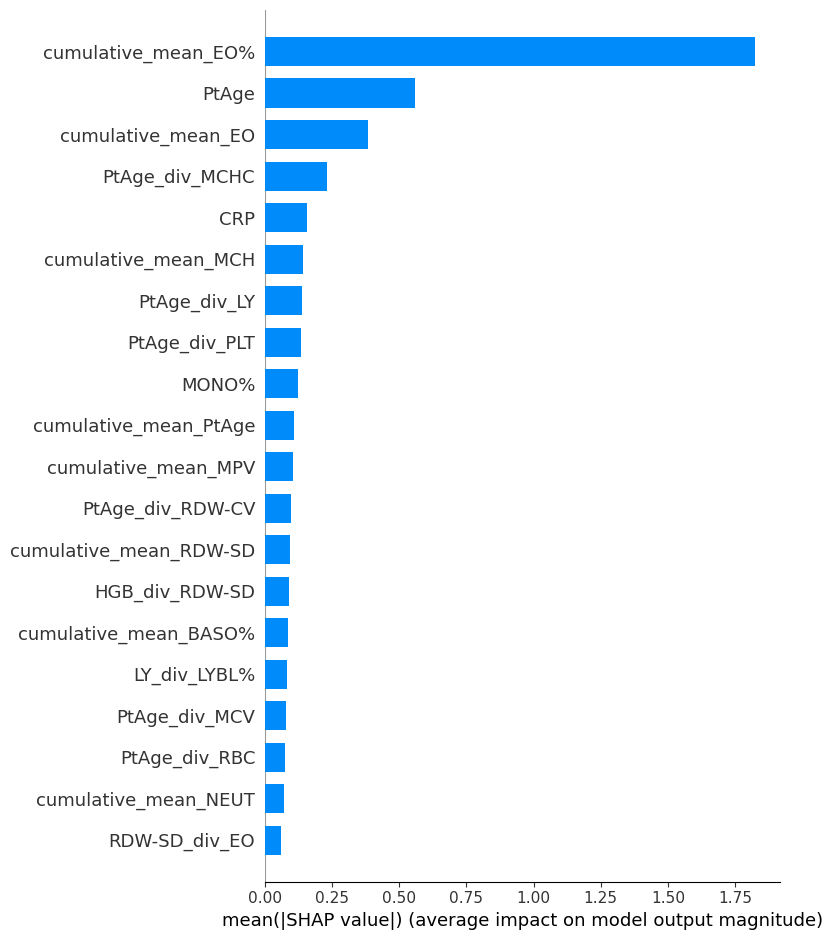

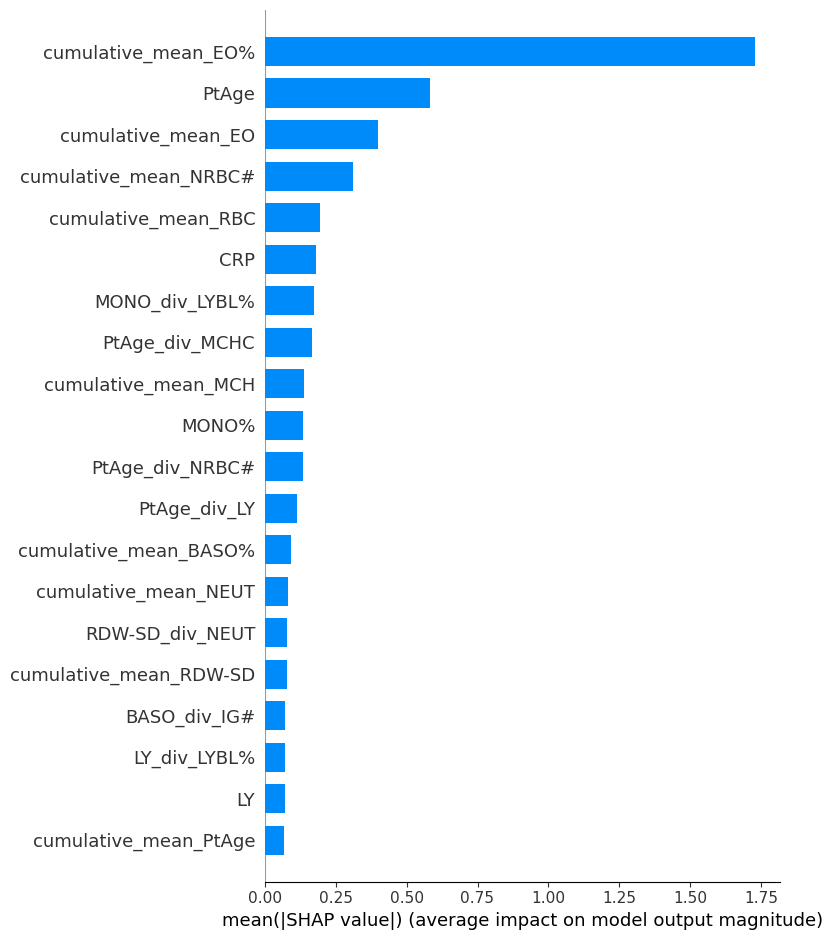

In [383]:
# use shap to explain the model's prediction for a single sample
import shap
shap.initjs()
explainer_1 = shap.TreeExplainer(multioutput_model_final.estimators_[0])
explainer_2 = shap.TreeExplainer(multioutput_model_final.estimators_[1])
shap_values_1 = explainer_1.shap_values(X_test_combined)
shap_values_2 = explainer_2.shap_values(X_test_combined)
shap.summary_plot(shap_values_1, X_test_combined, plot_type="bar")
shap.summary_plot(shap_values_2, X_test_combined, plot_type="bar")



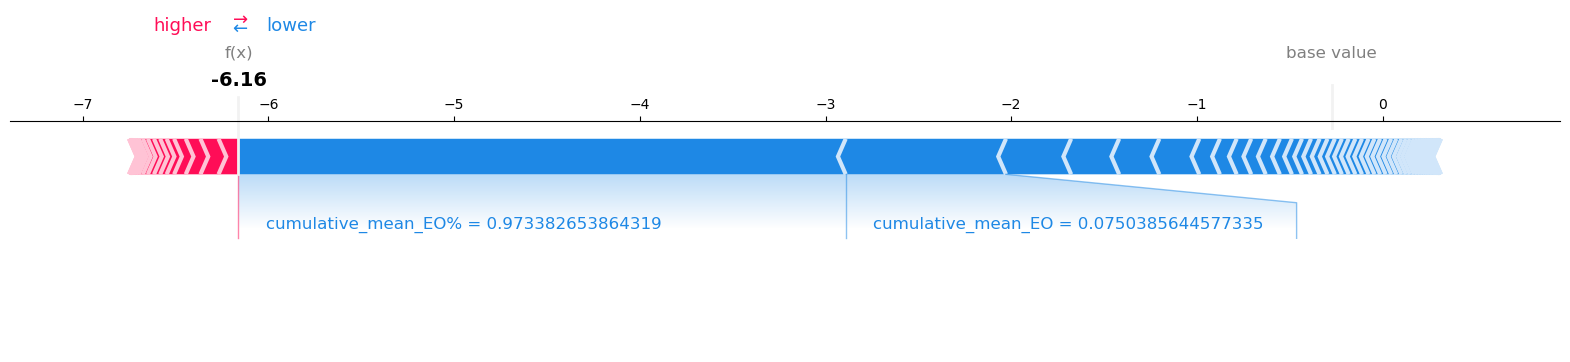

In [384]:
# use shap to explain the model's prediction in one line, use blue and red to indicate the feature value




shap.force_plot(explainer.expected_value[0], shap_values[25, :], X_test_combined.iloc[25,:], matplotlib=True, show=False)
# plt.savefig('shap.png', dpi=300, bbox_inches='tight')




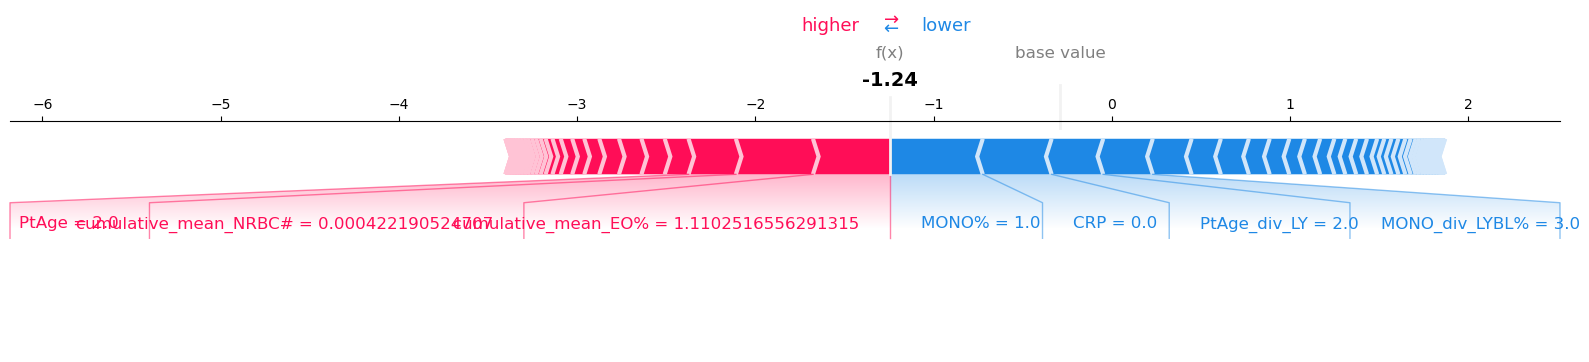

In [385]:
# plot the impact of each feature on the prediction for a single sample
shap.force_plot(explainer_2.expected_value, shap_values_2[20, :], X_test_combined.iloc[20,:], matplotlib=True, show=False)

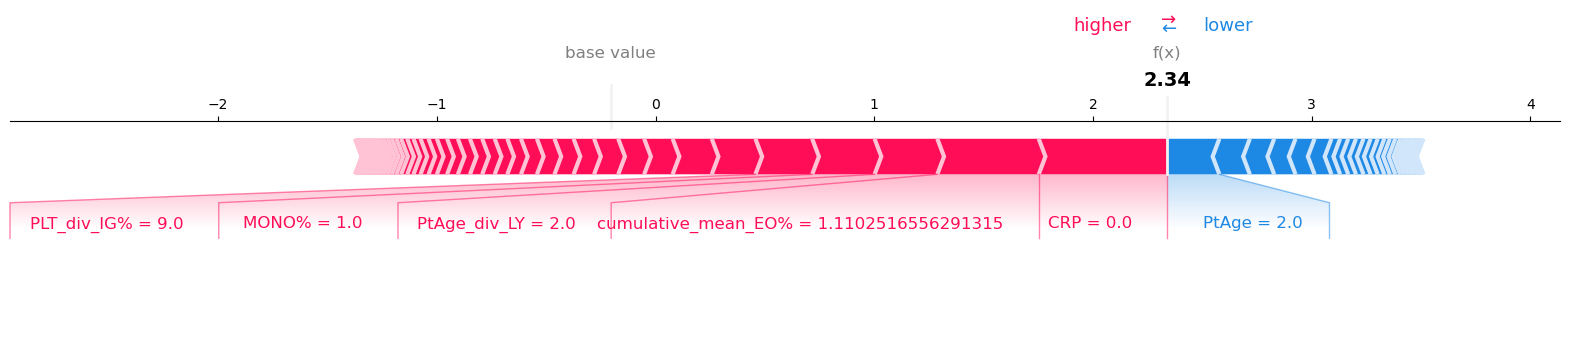

In [386]:
shap.force_plot(explainer_1.expected_value, shap_values_1[20, :], X_test_combined.iloc[20,:], matplotlib=True, show=False)

In [393]:
# check the xgboost模型的预测概率 for 第二十个样本
multioutput_model_final.predict_proba(X_test_combined.iloc[20,:].values.reshape(1, -1))



[array([[0.08788228, 0.9121177 ]], dtype=float32),
 array([[0.77610934, 0.22389066]], dtype=float32)]

In [387]:
explainer_1.expected_value

-0.20475265

In [388]:
xgb_predictions_comb[20]

array([1, 0, 0])

In [389]:
explainer_2.expected_value

-0.28890848

In [365]:
# use k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

# prepare the cross-validation procedure
kfold = KFold(n_splits=10)
# create model
model = MultiOutputClassifier(xgb.XGBClassifier(**best_params, eval_metric=['logloss', 'auc', 'error']))
# evaluate model
results = cross_val_score(model, data_combined, label, cv=kfold, scoring='accuracy')


[16:45:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth" } are not used.

[16:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth" } are not used.

[16:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth" } are not used.

[16:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth" } are not used.

[16:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", "estimator__learning_rate", "estimator__max_depth" } are not used.

[16:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "estimator__gamma", 

In [366]:
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 80.41% (14.21%)


AUC: 0.870


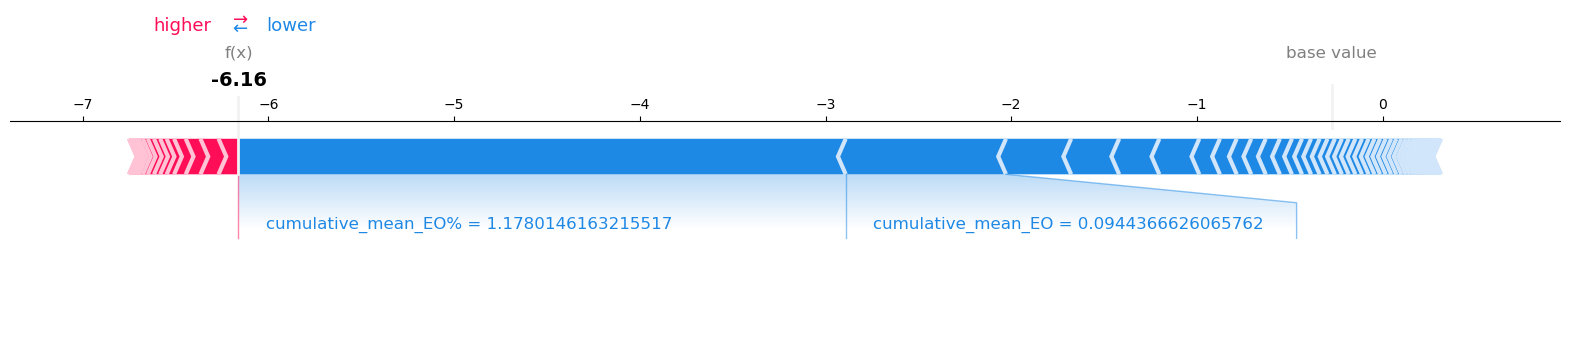

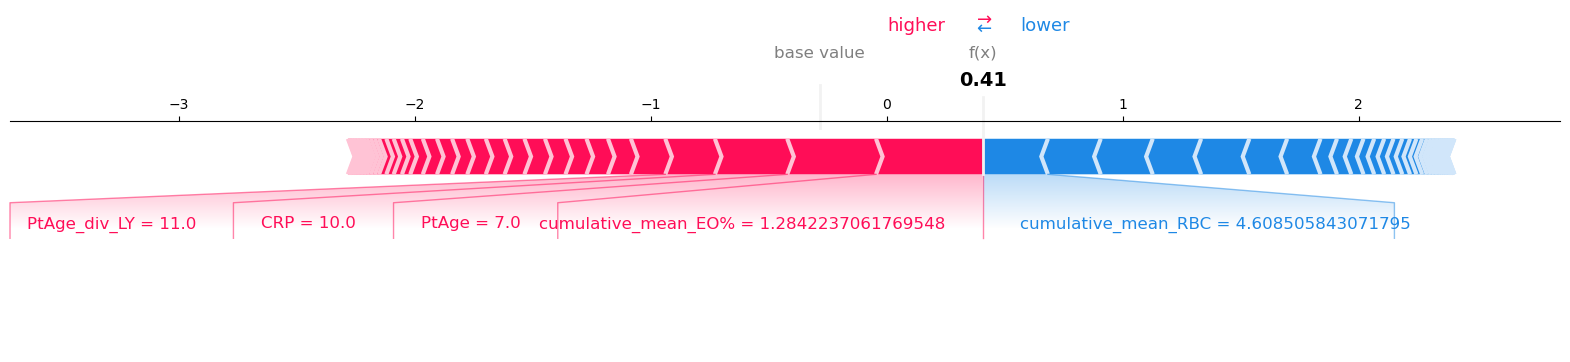

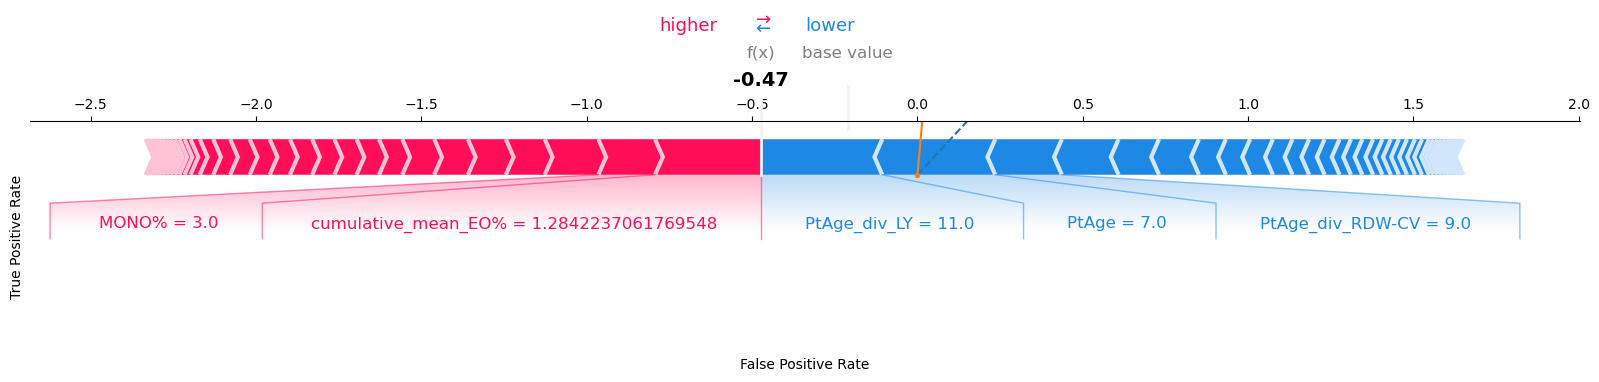

In [367]:
# test psi for my model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_combined['FYZ-IgM'], xgb_predictions_comb[:, 0])
roc_auc = roc_auc_score(y_test_combined['FYZ-IgM'], xgb_predictions_comb[:, 0])
print('AUC: %.3f' % roc_auc)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.show()

In [428]:
y_test_combined.iloc[:700,:].sum(axis=0)

FYZ-IgM    198
甲流         231
未感染        298
dtype: int64

In [429]:
y_test_combined.iloc[700:1400,:].sum(axis=0)

FYZ-IgM    201
甲流         235
未感染        286
dtype: int64